In [1]:
!pip install -r requirements.txt --quiet

In [2]:
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest, mannwhitneyu
from statannotations.Annotator import Annotator
from watermark import watermark

In [3]:
!mkdir Results

In [4]:
shutil.unpack_archive('test_results.zip', 'Results/')

In [5]:
#@title
def visSets(set1,set2,csvpath):
  dir_list = os.listdir(csvpath)
  print("Files and directories in '", path, "' :")

  well_set1=pd.DataFrame()
  well_set2=pd.DataFrame()

  # read csv of set 1
  for well in set1:
    for csv in dir_list:
      if csv.find(well, 0, 3) > -1:
        
        csv_set = pd.read_csv(csvpath+csv, sep=",")
        csv_set["Well"]=well
        well_set1 = pd.concat([well_set1, csv_set])

  # read csv of set 2
  for well in set2:
    for csv in dir_list:
      if csv.find(well, 0, 3) > -1:
        
        csv_set = pd.read_csv(csvpath+csv, sep=",")
        csv_set["Well"]=well
        well_set2 = pd.concat([well_set2, csv_set])

  return well_set1, well_set2

In [6]:
#@title
def pltoSet1(B23):
  sns.set_theme(style="ticks")

  # Initialize the figure with a logarithmic x axis
  f, ax = plt.subplots(figsize=(7, 6))

  # Plot the orbital period with horizontal boxes
  sns.boxplot(x="Well", y="Median", data=B23,
              width=.6, palette="vlag")

  # Add in points to show each observation
  #sns.swarmplot(x="Well", y="Median", data=B23,
  #              size=3, palette="vlag")

  # Tweak the visual presentation
  ax.xaxis.grid(True)
  ax.set(ylabel="Median")
  sns.despine(trim=True, left=True)

In [7]:
#@title
def norm_test(data, name):
  k2, p = normaltest(data)
  alpha = 1e-3
  print("p = {:g}".format(p))
  print('null hypothesis: {} comes from a normal distribution'.format(name))
  if p < alpha:  # null hypothesis: Data2 (Aptamil) from a normal distribution
      print("The null hypothesis can be rejected")
  else:
      print("The null hypothesis cannot be rejected")
  print("")

In [8]:
#@title
def visStats(set1,set2,path,stat_text,fig_name):
  well_set1, well_set2 = visSets(set1,set2,path)
  well_set1["Set"]=1
  well_set1["Well"].describe()

  well_set2["Set"]=2
  well_set2["Well"].describe()

  pltoSet1(well_set1)
  pltoSet1(well_set2)

  print("Statistics:")
  print('')

  csv_all=pd.concat([well_set1,well_set2])

  sns.set_theme(style="ticks")

  # Initialize the figure with a logarithmic x axis
  f, ax = plt.subplots(figsize=(7, 6))

  # Plot the orbital period with horizontal boxes
  sns.boxplot(x="Well", y="Median", data=csv_all,
              width=.6,
              hue="Set", palette=["m", "g"],)

  # Add in points to show each observation
  #sns.swarmplot(x="Well", y="Median", data=B23,
  #              size=3, palette="vlag")

  # Tweak the visual presentation
  #ax.xaxis.grid(True)
  ax.set(ylabel="Median")
  sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
  #sns.despine(trim=True, left=True)

  for well in set1:
    norm_test(csv_all[csv_all['Well']==well].Median, well)

  for well in set2:
    norm_test(csv_all[csv_all['Well']==well].Median, well)

  # pvalues with scipy:
  stat_results = [
    mannwhitneyu(csv_all[csv_all['Well']==set1[0]].Median, csv_all[csv_all['Well']==set2[0]].Median, alternative="two-sided"),
    mannwhitneyu(csv_all[csv_all['Well']==set1[0]].Median, csv_all[csv_all['Well']==set2[1]].Median, alternative="two-sided"),
    mannwhitneyu(csv_all[csv_all['Well']==set1[0]].Median, csv_all[csv_all['Well']==set2[2]].Median, alternative="two-sided"),
    mannwhitneyu(csv_all[csv_all['Well']==set1[1]].Median, csv_all[csv_all['Well']==set2[0]].Median, alternative="two-sided"),
    mannwhitneyu(csv_all[csv_all['Well']==set1[1]].Median, csv_all[csv_all['Well']==set2[1]].Median, alternative="two-sided"),
    mannwhitneyu(csv_all[csv_all['Well']==set1[1]].Median, csv_all[csv_all['Well']==set2[2]].Median, alternative="two-sided"),
    mannwhitneyu(csv_all[csv_all['Well']==set1[2]].Median, csv_all[csv_all['Well']==set2[0]].Median, alternative="two-sided"),
    mannwhitneyu(csv_all[csv_all['Well']==set1[2]].Median, csv_all[csv_all['Well']==set2[1]].Median, alternative="two-sided"),
    mannwhitneyu(csv_all[csv_all['Well']==set1[2]].Median, csv_all[csv_all['Well']==set2[2]].Median, alternative="two-sided"),
    # mannwhitneyu(robots, sound, alternative="two-sided")
  ]

  pvalues = [result.pvalue for result in stat_results]
  print(pvalues)

  pairs = [(set1[0], set2[0]),
           (set1[0], set2[1]), 
           (set1[0], set2[2]),   
          (set1[1], set2[0]), 
           (set1[1], set2[1]),
           (set1[1], set2[2]),
          (set1[2], set2[0]),
           (set1[2], set2[1]), 
           (set1[2], set2[2]),  
          #  ('Robots', 'Sound')   # 'Robots' vs 'Sound'
          ]

  formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

  # prepare plots
  subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)
  states_palette = sns.color_palette("YlGnBu", n_colors=5)

  cmap=sns.color_palette("colorblind")
  plotting_parameters = {
      'data':csv_all, 
      'x':'Well', 
      'y':'Median', 
      'showfliers': False,
      'width':.6,
      #'hue':"Set",
      'palette':[cmap[0], cmap[1], cmap[4],cmap[0], cmap[1], cmap[4]],
  }

  # show results
  with sns.plotting_context('notebook', font_scale=1.4):
    # Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # Plot with seaborn
    sns.boxplot(**plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    ## p values
    #annotator.set_custom_annotations(formatted_pvalues)
    #annotator.annotate()

    ## <> p values
    annotator.configure(text_format="simple")
    annotator.set_pvalues(pvalues).annotate()
    

    # Label and show
    plt.title(stat_text, y=1.06)
    
    plt.savefig("./"+fig_name+".png", bbox_inches='tight')
    plt.show()

In [9]:
# set1 = ["B2", "C2", "D2"] #ok
# set2 = ["B3", "C3", "D3"]

# set1 = ['E6', 'F6', 'G6'] #ok
# set2 = ['E7', 'F7', 'G7']

# set1 = ['E9', 'F9', 'G9'] #nope
# set2 = ['E10', 'F10', 'G10']

set1 = ['B9', 'C9', 'D9'] #ok
set2 = ['B10', 'C10', 'D10'] #B10, C10, D10

In [10]:
path="Results/"

In [11]:
#@title
dir_list = os.listdir(path)
 
print("Files and directories in '", path, "' :")
 
# prints all files
print(dir_list)

Files and directories in ' Results/ ' :
['B10_AllResults_2023-1-30_Results.csv', 'B2_AllResults_2023-1-30_Results.csv', 'B3_AllResults_2023-1-30_Results.csv', 'B9_AllResults_2023-1-30_Results.csv', 'C10_AllResults_2023-1-30_Results.csv', 'C2_AllResults_2023-1-30_Results.csv', 'C3_AllResults_2023-1-30_Results.csv', 'C9_AllResults_2023-1-30_Results.csv', 'D10_AllResults_2023-1-30_Results.csv', 'D2_AllResults_2023-1-30_Results.csv', 'D3_AllResults_2023-1-30_Results.csv', 'D9_AllResults_2023-1-30_Results.csv', 'E6_AllResults_2023-1-30_Results.csv', 'E7_AllResults_2023-1-30_Results.csv', 'F6_AllResults_2023-1-30_Results.csv', 'F7_AllResults_2023-1-30_Results.csv', 'G6_AllResults_2023-1-30_Results.csv', 'G7_AllResults_2023-1-30_Results.csv']


Files and directories in ' Results/ ' :
Statistics:

p = 8.5405e-165
null hypothesis: B9 comes from a normal distribution
The null hypothesis can be rejected

p = 2.08779e-295
null hypothesis: C9 comes from a normal distribution
The null hypothesis can be rejected

p = 5.67806e-287
null hypothesis: D9 comes from a normal distribution
The null hypothesis can be rejected

p = 6.35529e-65
null hypothesis: B10 comes from a normal distribution
The null hypothesis can be rejected

p = 1.58751e-51
null hypothesis: C10 comes from a normal distribution
The null hypothesis can be rejected

p = 4.36442e-69
null hypothesis: D10 comes from a normal distribution
The null hypothesis can be rejected

[1.7630791199400455e-11, 8.717445236450443e-25, 4.997708561609295e-11, 4.236589023745525e-26, 3.58691105716953e-45, 1.3470964567997893e-25, 5.6575973815114486e-27, 4.2461549409870144e-46, 1.9310807503029954e-26]
D9 vs. B10: Custom statistical test, P_val:5.658e-27
C9 vs. B10: Custom statistical test, P_va

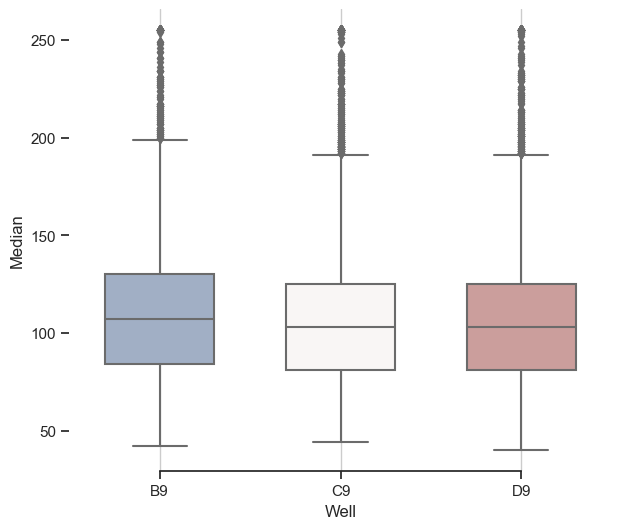

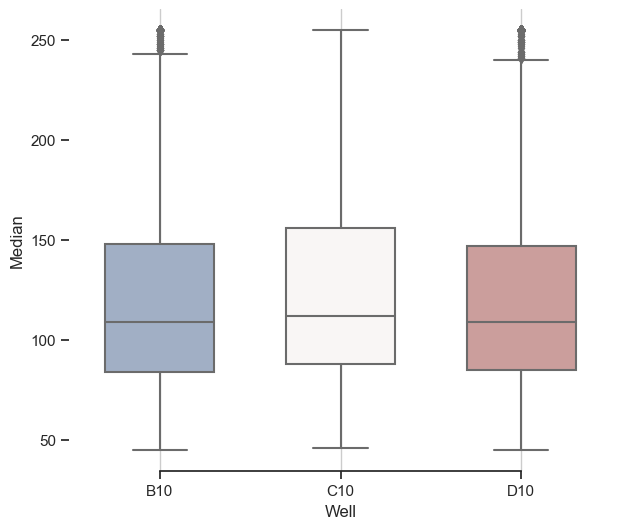

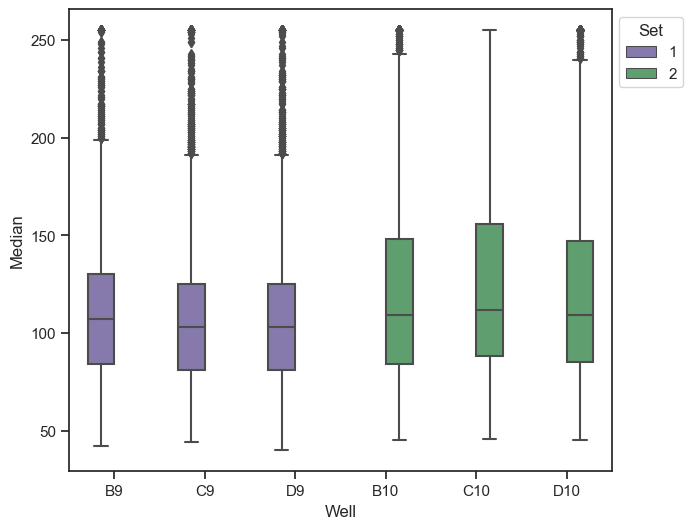

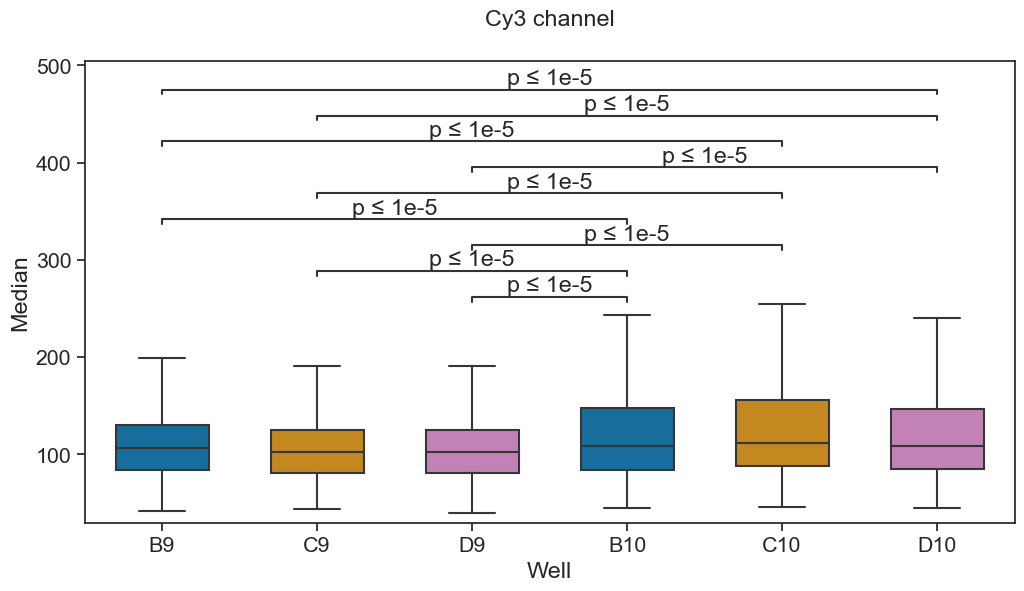

In [12]:
visStats(set1,set2,path,"Cy3 channel",''.join(set1)+''.join(set2))

In [13]:
well_set1, well_set2 = visSets(set1,set2,path)
well_set1["Set"]=1
well_set1["Well"].describe()

well_set2["Set"]=2
well_set2["Well"].describe()

m2a1=well_set1["Mean"].mean()/well_set1["Area"].mean()
print(m2a1)
m2a2=well_set2["Mean"].mean()/well_set2["Area"].mean()
print(m2a2)

print("Mean Brigthnes")
print(well_set1["Mean"].mean())
print(well_set2["Mean"].mean())

print("Mean Area")
print(well_set1["Area"].mean())
print(well_set2["Area"].mean())

print("Fold: {}".format(m2a2/m2a1))

Files and directories in ' Results/ ' :
33315.35404544509
78207.80431892823
Mean Brigthnes
106.46605948204778
124.45430203865624
Mean Area
0.003195705479726214
0.0015913284246050008
Fold: 2.347500321090566


In [14]:
watermark(iversions=True, globals_=globals())
print(watermark())

Last updated: 2023-02-04T11:11:38.971920+01:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.9.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [15]:
print(watermark(packages="watermark,numpy,pandas,seaborn,scipy,statannotations,statsmodels"))

watermark      : 2.3.1
numpy          : 1.24.1
pandas         : 1.5.3
seaborn        : 0.11.2
scipy          : 1.10.0
statannotations: 0.5.0
statsmodels    : 0.13.5

